# Emojify! 

In this project, I'm going to use word vector representations to build an Emojifier. 
🤩 💫 🔥

It can make text messages semm more expressive.

Rather than writing:
>"Congratulations on the promotion! Let's get coffee and talk. Love you!"   

The emojifier can automatically turn this into:
>"Congratulations on the promotion! 👍  Let's get coffee and talk. ☕️ Love you! ❤️"

I'll implement a model which inputs a sentence (such as "Let's go see the baseball game tonight!") and finds the most appropriate emoji to be used with this sentence (⚾️).

### Using Word Vectors to Improve Emoji Lookups
* In many emoji interfaces, ❤️  is the "heart" symbol rather than the "love" symbol. 
    * In other words, typing "heart" will find the desired emoji, and typing "love" won't bring up that symbol.
* I will make a more flexible emoji interface by using word vectors!
* When using word vectors, even if the training set explicitly relates only a few words to a particular emoji, the algorithm will be able to generalize and associate additional words in the test set to the same emoji.
    * This works even if those additional words don't even appear in the training set. 
    * This allows building an accurate classifier mapping from sentences to emojis, even using a small training set. 

### What I'll build:
1. In this project, I'll start with a baseline model (Emojifier-V1) using word embeddings.
2. Then I will build a more sophisticated model (Emojifier-V2) that further incorporates an LSTM. 

**Project Objectives:**

* Create an embedding layer in Keras with pre-trained word vectors
* Emphasize the advantages and disadvantages of the GloVe algorithm
* Implement negative sampling, which learns word vectors more efficiently than other methods
* Build a sentiment classifier using word embeddings
* Build and train a more sophisticated classifier using an LSTM

🏀 👑

👆 😎

(^^^ Emoji for "skills") 

## Table of Contents

- [Packages](#0)
- [1 - Baseline Model: Emojifier-V1](#1)
    - [1.1 - Dataset EMOJISET](#1-1)
    - [1.2 - Overview of the Emojifier-V1](#1-2)
    - [1.3 - Implementing Emojifier-V1](#1-3)
        - [sentence_to_avg](#-)
    - [1.4 - Implement the Model](#1-4)
        - [model](#-)
    - [1.5 - Examining Test Set Performance](#1-5)
- [2 - Emojifier-V2: Using LSTMs in Keras](#2)
    - [2.1 - Model Overview](#2-1)
    - [2.2 Keras and Mini-batching](#2-2)
    - [2.3 - The Embedding Layer](#2-3)
        - [sentences_to_indices](#-)
        - [pretrained_embedding_layer](#-)
    - [2.4 - Building the Emojifier-V2](#2-4)
        - [Emojify_V2](#-)
    - [2.5 - Train the Model](#2-5)
- [3 - Acknowledgments](#3)

<a name='0'></a>
## Packages

loading the packages needed. 

In [8]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt
from test_utils import *

%matplotlib inline

<a name='1'></a>
## 1 - Baseline Model: Emojifier-V1

<a name='1-1'></a>
### 1.1 - Dataset EMOJISET

I'll start by building a simple baseline classifier. 

Given a tiny dataset (X, Y) where:
- X contains 127 sentences (strings).
- Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence.

<img src="images/data_set.png" style="width:700px;height:300px;">
<caption><center><font color='purple'><b>Figure 1</b>: EMOJISET - a classification problem with 5 classes. A few examples of sentences are given here. </center></caption>

Load the dataset: the dataset is split between training (127 examples) and testing (56 examples).

In [29]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [30]:
maxLen = len(max(X_train, key=len).split())

Printing sentences from X_train and corresponding labels from Y_train. 

In [4]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


<a name='1-2'></a>
### 1.2 - Overview of the Emojifier-V1

a baseline model called "Emojifier-v1":  

<center>
<img src="images/image_1.png" style="width:900px;height:300px;">
    <caption><center><font color='purple'><b>Figure 2</b>: Baseline model (Emojifier-V1).</center></caption>
</center></font>


#### Inputs and Outputs
* The input of the model is a string corresponding to a sentence (e.g. "I love you"). 
* The output will be a probability vector of shape (1,5), (indicating that there are 5 emojis to choose from).
* The (1,5) probability vector is passed to an argmax layer, which extracts the index of the emoji with the highest probability.

#### One-hot Encoding
* Using one-hot encoding to get the labels into a format suitable for training a softmax classifier, convert $Y$ from its current shape  $(m, 1)$ into a "one-hot representation" $(m, 5)$, 
    * Each row is a one-hot vector giving the label of one example.
    * Here, `Y_oh` stands for "Y-one-hot" in the variable names `Y_oh_train` and `Y_oh_test`: 

In [5]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

`convert_to_one_hot()` does the follwing:

In [6]:
idx = 50
print(f"Sentence '{X_train[idx]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


All the data is now ready to be fed into the Emojify-V1 model. 

<a name='1-3'></a>
### 1.3 - Implementing Emojifier-V1

As shown in Figure 2 (above), the first step is to:
* Convert each word in the input sentence into their word vector representations.
* Take an average of the word vectors. 

I'll use a pre-trained 50-dimensional GloVe embeddings. 

`word_to_vec_map`: contains all the vector representations.

In [13]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

I've loaded:
- `word_to_index`: dictionary mapping from words to their indices in the vocabulary 
    - (400,001 words, with the valid indices ranging from 0 to 400,000)
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.

The following cell ensures it works:

In [8]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


<a name='-'></a>
### sentence_to_avg

Implementing `sentence_to_avg()` using two steps:

1. Convert every sentence to lower-case, then split the sentence into a list of words. 😉
2. For each word in the sentence, access its GloVe representation.
    * Then take the average of all of these word vectors.

In [9]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (J,), where J can be any number
    """
    # Get a valid word contained in the word_to_vec_map. 
    any_word = list(word_to_vec_map.keys())[0]
    
    # Step 1: Split sentence into list of lower case words 
    words = sentence.lower().split()

    # Initialize the average word vector, having the same shape as the word vectors.
    avg = np.zeros(word_to_vec_map[any_word].shape)
    
    # Initialize count to 0
    count = 0
    
    # Step 2: average the word vectors by looping over the words in the list "words".
    for w in words:
        # Check that word exists in word_to_vec_map
        if w in word_to_vec_map:
            avg += word_to_vec_map[w]
            # Increment count
            count +=1
          
    if count > 0:
        # Get the average. But only if count > 0
        avg = avg / count

    return avg

<a name='1-4'></a>
### 1.4 - Implement the Model

Now, all the pieces to finish implementing the `model()` function are ready: 
After using `sentence_to_avg()` I will do the follwing:
* Pass the average through forward propagation
* Compute the cost
* Backpropagate to update the softmax parameters

<a name='-'></a>
### model

The `model()` function described in Figure (2): 

* The equations needed to implement in the forward pass and to compute the cross-entropy cost are below:
* The variable $Y_{oh}$ ("Y one hot") is the one-hot encoding of the output labels. 

$$ z^{(i)} = Wavg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$

**Note**: It is possible to come up with a more efficient vectorized implementation. For now, I'll just use nested for loops to better understand the algorithm and implement it step by step

In [10]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m,)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    # Get a valid word contained in the word_to_vec_map 
    any_word = list(word_to_vec_map.keys())[0]
        
    # Define number of training examples
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        
        cost = 0
        dW = 0
        db = 0
        
        for i in range(m):          # Loop over the training examples
            
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[1], word_to_vec_map)

            # Forward propagate the avg through the softmax layer. 
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Add the cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost += - np.sum(np.multiply(Y_oh[i], np.log(a)))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW += np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db += dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) # predict is defined in emo_utils.py

    return pred, W, b

Next, I'll train the model and learn the softmax parameters (W, b).

In [41]:
np.random.seed(1)
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 517.2366217015639
Accuracy: 0.15151515151515152
Epoch: 100 --- cost = 1587.6790134979858
Accuracy: 0.14393939393939395
Epoch: 200 --- cost = 1269.7502760753803
Accuracy: 0.2803030303030303
Epoch: 300 --- cost = 2335.8348518256457
Accuracy: 0.2727272727272727
[[3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [4.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 

The model has pretty high accuracy on the training set. 
Next step is to evaluate it on the test set:

<a name='1-5'></a>
### 1.5 - Examining Test Set Performance 

The `predict` function used here is defined in `emo_util.py`.

In [42]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.16666666666666666
Test set:
Accuracy: 0.125


**Note**:
* Random guessing would have had 20% accuracy, given that there are 5 classes. (1/5 = 20%).
* This is pretty good performance after training on only 127 examples. 


#### The Model Matches Emojis to Relevant Words
In the training set, the algorithm saw the sentence 
>"I love you." 

with the label ❤️. 
* The word "cherish" does not appear in the training set. 
* Nonetheless, see what happens if you write "I cherish you."

In [43]:
X_my_sentences = np.array(["i cherish you", "i love you", "funny lol", 
                           "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.3333333333333333

i cherish you ❤️
i love you ❤️
funny lol ❤️
lets play with a ball ❤️
food is ready ❤️
not feeling happy ❤️


* Because *adore* has a similar embedding as *love*, the algorithm has generalized correctly even to a word it has never seen before. 
* Words such as *heart*, *dear*, *beloved* or *adore* have embedding vectors similar to *love*. 

#### Word Ordering isn't Considered in this Model
* Note that the model doesn't get the following sentence correct:
>"not feeling happy" 

* This algorithm ignores word ordering, so is not good at understanding phrases like "not happy." 

#### Confusion Matrix
* The confusion matrix can also help in understanding which classes are more difficult for the model. 

Printing the confusion matrix below:

(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  4.0  All
Actual                  
0            7    0    7
1            8    0    8
2           17    1   18
3           16    0   16
4            7    0    7
All         55    1   56


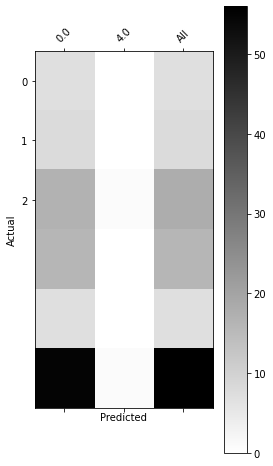

In [44]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

<font color='blue'><b>Key notes:</b>
- Even with a mere 127 training examples, I got a reasonably good model for Emojifying. 
    - This is due to the generalization power word vectors gives. 
- Emojify-V1 will perform poorly on sentences such as *"This movie is not good and not enjoyable"* 
    - It doesn't understand combinations of words.
    - It just averages all the words' embedding vectors together, without considering the ordering of words. 
</font>
    
**I will build a better algorithm in the next section!**

<a name='2'></a>
## 2 - Emojifier-V2: Using LSTMs in Keras 

I'm going to build an LSTM model that takes word **sequences** as input! This model will be able to account for word ordering. 

Emojifier-V2 will continue to use pre-trained word embeddings to represent words. I'll feed word embeddings into an LSTM, and the LSTM will learn to predict the most appropriate emoji. 

### Packages

loading the Keras packages needed:

In [1]:
import numpy as np
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

<a name='2-1'></a>
### 2.1 - Model Overview

Here is the Emojifier-v2 that will be implemented:

<img src="images/emojifier-v2.png" style="width:700px;height:400px;"> <br>
<caption><center><font color='purple'><b>Figure 3</b>: Emojifier-V2. A 2-layer LSTM sequence classifier. </center></caption>

<a name='2-2'></a>
### 2.2 Keras and Mini-batching 

In this exercise, I'll train Keras using mini-batches. However, most deep learning frameworks require that all sequences in the same mini-batch have the **same length**. 

This is what allows vectorization to work: If we had a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both at the same time.
    
#### Padding Handles Sequences of Varying Length
* The common solution to handling sequences of **different length** is to use padding.  Specifically:
    * Set a maximum sequence length
    * Pad all sequences to have the same length. 
    
#### Example of Padding:
* Given a maximum sequence length of 20, pad every sentence with "0"s so that each input sentence is of length 20. 
* Thus, the sentence "I love you" would be represented as $(e_{I}, e_{love}, e_{you}, \vec{0}, \vec{0}, \ldots, \vec{0})$. 
* In this example, any sentences longer than 20 words would have to be truncated. 
* One way to choose the maximum sequence length is to just pick the length of the longest sentence in the training set. 

<a name='2-3'></a>
### 2.3 - The Embedding Layer

In Keras, the embedding matrix is represented as a "layer."

* The embedding matrix maps word indices to embedding vectors.
    * The word indices are positive integers.
    * The embedding vectors are dense vectors of fixed size.
    * A "dense" vector is the opposite of a sparse vector. It means that most of its values are non-zero.  As a counter-example, a one-hot encoded vector is not "dense."
* The embedding matrix can be derived in two ways:
    * Training a model to derive the embeddings from scratch. 
    * Using a pretrained embedding.
    
#### Using and Updating Pre-trained Embeddings
In this section, I'll create an [Embedding()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer in Keras

* I'll initialize the Embedding layer with GloVe 50-dimensional vectors. 
* Keras allows to either train or leave this layer fixed.  
    * Because the training set is quite small, I'll leave the GloVe embeddings fixed instead of updating them.

#### Inputs and Outputs to the Embedding Layer

* The `Embedding()` layer's input is an integer matrix of size **(batch size, max input length)**. 
    * This input corresponds to sentences converted into lists of indices (integers).
    * The largest integer (the highest word index) in the input should be no larger than the vocabulary size.
* The embedding layer outputs an array of shape (batch size, max input length, dimension of word vectors).

* The figure shows the propagation of two example sentences through the embedding layer. 
    * Both examples have been zero-padded to a length of `max_len=5`.
    * The word embeddings are 50 units in length.
    * The final dimension of the representation is  `(2,max_len,50)`. 

<img src="images/embedding1.png" style="width:700px;height:250px;">
<caption><center><font color='purple'><b>Figure 4</b>: Embedding layer</center></caption>

#### Prepare the Input Sentences

<a name='-'></a>
### sentences_to_indices

`sentences_to_indices`:

This function processes an array of sentences X and returns inputs to the embedding layer:

* Convert each training sentences into a list of indices (the indices correspond to each word in the sentence)
* Zero-pad all these lists so that their length is the length of the longest sentence.

In [2]:
for idx, val in enumerate(["I", "like", "learning"]):
    print(idx, val)

0 I
1 like
2 learning


In [11]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m,)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape 
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. Should get a list of words.
        sentence_words = [w.lower() for w in X[i].split()]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words

        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j +=1  

    return X_indices

To check what `sentences_to_indices()` does and get a look at the results:

In [14]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


#### Build Embedding Layer

Now I'll build the `Embedding()` layer in Keras, using pre-trained word vectors. 

* The embedding layer takes as input a list of word indices.
    * `sentences_to_indices()` creates these word indices.
* The embedding layer will return the word embeddings for a sentence. 

<a name='-'></a>
### pretrained_embedding_layer

Implement `pretrained_embedding_layer()` with these steps:

1. Initialize the embedding matrix as a numpy array of zeros.
    * The embedding matrix has a row for each unique word in the vocabulary.
        * There is one additional row to handle "unknown" words.
        * So vocab_size is the number of unique words plus one.
    * Each row will store the vector representation of one word. 
        * For example, one row may be 50 positions long if using GloVe word vectors.
    * In the code below, `emb_dim` represents the length of a word embedding.
2. Fill in each row of the embedding matrix with the vector representation of a word
    * Each word in `word_to_index` is a string.
    * word_to_vec_map is a dictionary where the keys are strings and the values are the word vectors.
3. Define the Keras embedding layer. 
    * The input dimension is equal to the vocabulary length (number of unique words plus one).
    * The output dimension is equal to the number of positions in a word embedding.
    * Make this layer's embeddings fixed.
        * If I were to set `trainable = True`, then it will allow the optimization algorithm to modify the values of the word embeddings.
        * In this case, I don't want the model to modify the word embeddings.
4. Set the embedding weights to be equal to the embedding matrix.

In [17]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of the GloVe word vectors (= 50)

    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_size, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_size, emb_dim, trainable = False)

    # Step 4 
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) 
    
    # Set the weights of the embedding layer to the embedding matrix. The layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [19]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50


<a name='2-4'></a>
### 2.4 - Building the Emojifier-V2

Now to build the Emojifier-V2 model, in which I'll feed the embedding layer's output to an LSTM network!

<img src="images/emojifier-v2.png" style="width:700px;height:400px;"> <br>
<caption><center><font color='purple'><b>Figure 3</b>: Emojifier-v2. A 2-layer LSTM sequence classifier. </center></caption></font> 


<a name='-'></a>
### Emojify_V2

Implement `Emojify_V2()`:

This function builds a Keras graph of the architecture shown in Figure (3). 

* The model takes as input an array of sentences of shape (`m`, `max_len`, ) defined by `input_shape`. 
* The model outputs a softmax probability vector of shape (`m`, `C = 5`). 

In [24]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors 
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units = 128, return_sequences = True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(X) 
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units = 128, return_sequences = False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(X)  
    # Propagate X through a Dense layer with 5 units
    X = Dense(units = 5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = sentence_indices, outputs = X)

    return model

Next step is to create the model and check its summary. 

* Because all sentences in the dataset are less than 10 words, `max_len = 10` was chosen.  
* The neural network architecture uses 20,223,927 parameters, of which 20,000,050 (the word embeddings) are non-trainable, with the remaining 223,877 being trainable. 
* Because your vocabulary size has 400,001 words (with valid indices from 0 to 400,000) there are 400,001\*50 = 20,000,050 non-trainable parameters. 

In [31]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                

#### Compile the Model 

As usual, after creating the model in Keras, we need to compile it and define what loss, optimizer and metrics to be used. I will compile the model below using `categorical_crossentropy` loss, `adam` optimizer and `['accuracy']` metric:

In [32]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<a name='2-5'></a>
### 2.5 - Train the Model 

Now, it's time to train the model
Emojifier-V2 `model` takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of classes`). Thus, X_train (array of sentences as strings)  must be converted to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

In [33]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

Fitting the Keras model on `X_train_indices` and `Y_train_oh`, using `epochs = 50` and `batch_size = 32`:

In [34]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
5/5 [==============================] - 0s 28ms/step - loss: 1.5870 - accuracy: 0.3030
Epoch 2/50
5/5 [==============================] - 0s 37ms/step - loss: 1.5109 - accuracy: 0.2879
Epoch 3/50
5/5 [==============================] - 0s 23ms/step - loss: 1.4694 - accuracy: 0.3182
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 1.3745 - accuracy: 0.4545
Epoch 5/50
5/5 [==============================] - 0s 23ms/step - loss: 1.3067 - accuracy: 0.4621
Epoch 6/50
5/5 [==============================] - 0s 34ms/step - loss: 1.1796 - accuracy: 0.5227
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 1.0256 - accuracy: 0.5985
Epoch 8/50
5/5 [==============================] - 0s 23ms/step - loss: 0.9550 - accuracy: 0.6439
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 0.8309 - accuracy: 0.7121
Epoch 10/50
5/5 [==============================] - 0s 23ms/step - loss: 0.7731 - accuracy: 0.7045
Epoch 11/50
5/5 [============

the model performs **100% accuracy** on the training set.

Next is to evaluate the model on the test set: 

In [35]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 0s 2ms/step - loss: 0.4562 - accuracy: 0.8750

Test accuracy =  0.875


the model performs around **87.5% accuracy** on the training set.
The cell below shows mislabelled examples: 

In [36]:
# Mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:❤️ prediction: I love taking breaks	😞
Expected emoji:😄 prediction: you brighten my day	😞
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:😞 prediction: go away	⚾


if you are reading this, try it on your own example! 
Write your own sentence below:

In [40]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['I loved this project'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

I loved this project 😄


#### LSTM Version Accounts for Word Order
* The Emojify-V1 model did not identify "not feeling happy" correctly, but the implementation of Emojify-V2 got it right! 
* The current model still isn't very robust at understanding negation (such as "not happy")
    * This is because the training set is small and doesn't have a lot of examples of negation. 
    * If the training set were larger, the LSTM model would be much better than the Emojify-V1 model at understanding more complex sentences. 

### Conclusion:
 
This project harnessed the power of LSTMs to make words more emotive! ❤️❤️❤️

**Revisiting project objectives**: 

* Created an embedding matrix
* Observed how negative sampling learns word vectors more efficiently than other methods
* Experienced the advantages and disadvantages of the GloVe algorithm
* And built a sentiment classifier using word embeddings! 

Emojified: 😎😎😎  

<font color='blue'><b>Final Notes:</b>:
- If you have an NLP task where the training set is small, using word embeddings can help the algorithm significantly. 
- Word embeddings allow models to work on words in the test set that may not even appear in the training set. 
- Training sequence models in Keras (and in most other deep learning frameworks) requires a few important details:
    - To use mini-batches, the sequences need to be **padded** so that all the examples in a mini-batch have the **same length**. 
    - An `Embedding()` layer can be initialized with pretrained values. 
        - These values can be either fixed or trained further on your dataset. 
        - If however your labeled dataset is small, it's usually not worth trying to train a large pre-trained set of embeddings.   
    - `LSTM()` has a flag called `return_sequences` to decide if you would like to return every hidden states or only the last one. 
    - `Dropout()` can be used right after `LSTM()` to regularize the network. 


### Input sentences:
```Python
"I'm happy that I finished this project and built an Emojifier."
```
### Output emojis:
# 😀😀😀😀😀😀

☁ 👋🚀 ☁☁

      ✨ BYE-BYE!
      
☁ ✨  🎈

      ✨  ☁
  
         ✨
 
     ✨
 
🌾✨💨 🏃 🏠🏢                    

<a name='3'></a>
## 3 - Acknowledgments

Thanks to Alison Darcy and the Woebot team for their advice on the creation of this project. 
* Woebot is a chatbot friend that is ready to speak with you 24/7. 
* Part of Woebot's technology uses word embeddings to understand the emotions of what you say. 
* You can chat with Woebot by going to http://woebot.io

<img src="images/woebot.png" style="width:600px;height:300px;">